In [2]:
import geopandas as gpd
import pandas as pd

In [13]:
cri_ef = gpd.read_file("/Users/heatherbaier/Documents/geo_git/data/CRI/cri_schools/CE_PUBLICOS_SABER_JUN24.shp")
cri_ef["CODSABER"] = cri_ef["CODSABER"].astype(str).str.split("-").str[0]
cri_ef.head()

,OBJECTID,CODSABER,CODPRES,CENTRO_EDU,TIPO_INSTI,ESTADO,CORREO,REGIONAL,CIRCUITO,PROVINCIA,CANTON,DISTRITO,POBLADO,DIRECCION,LATITUD,LONGITUD,geometry
0,1.0,100517,0306,EL CARMEN,PÚBLICO,ACTIVO,esc.elcarmenescazu@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ OESTE,CIRCUITO 03,SAN JOSÉ,ESCAZÚ,SAN ANTONIO,EL CARMEN,25 SUR DE IGLESIA CATOLICA. EL CARMEN,9.896753,-84.141212,POINT (484514.254 1094328.781)
1,2.0,100518,0307,DAVID MARÍN HIDALGO,PÚBLICO,ACTIVO,esc.davidmarinhidalgo@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ OESTE,CIRCUITO 03,SAN JOSÉ,ESCAZÚ,SAN ANTONIO,BEBEDERO,200 SUR DE LA IGLESIA CATOLICA,9.903270,-84.159654,POINT (482492.224 1095050.427)
2,3.0,100519,0308,BELLO HORIZONTE,PÚBLICO,ACTIVO,esc.bellohorizonteescazu@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ OESTE,CIRCUITO 03,SAN JOSÉ,ESCAZÚ,SAN RAFAEL,BELO HORIZONTE,75 METROS SUROESTE DEL TEMPLO CATOLICO,9.919351,-84.130008,POINT (485743.919 1096827.478)
3,4.0,100520,0309,BETANIA,PÚBLICO,ACTIVO,esc.betaniamontesdeoca@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ NORTE,CIRCUITO 03,SAN JOSÉ,MONTES DE OCA,MERCEDES,BETANIA,100 ESTE DE LA ROTONDA DE LA BANDERA,9.939712,-84.053562,POINT (494126.998 1099077.058)
4,5.0,100521,0310,BRASIL DE SANTA ANA,PÚBLICO,ACTIVO,esc.brasildesantaana@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ OESTE,CIRCUITO 04,SAN JOSÉ,SANTA ANA,BRASIL,BRASIL,200 SUROESTE DE PARADA DE BUSES TAPACHULA,9.935435,-84.224808,POINT (475349.716 1098611.875)


In [9]:
df = pd.read_excel("/Users/heatherbaier/Documents/geo_git/data/CRI/REPITENTES_EN_ESCUELAS_2014-2022.xlsx")
df.head()

,"Estudiantes repitentes en I y II Ciclos, 2014-2022",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,Nota: No incluye los datos del curso lectivo 2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4°,NaN,NaN,5°,NaN,NaN,6°,NaN,NaN
1,CURSO LECTIVO,CODIGO,NOMBRE,REGION,CIRES,PROVINCIA,CANTON,DISTRITO,POBLADO,SECTOR,...,RM03,RT04,RH04,RM04,RT05,RH05,RM05,RT06,RH06,RM06
2,2014,1945,BLÖRIÑAK,TURRIALBA,07,CARTAGO,TURRIALBA,CHIRRIPO,BLÖRIÑAK,1,...,5,5,3,2,2,1,1,6,0,6
3,2014,1967,SARKLI,TURRIALBA,06,CARTAGO,TURRIALBA,CHIRRIPO,SARCLI,1,...,0,1,0,1,1,1,0,0,0,0
4,2014,4971,TULËSI,TURRIALBA,07,CARTAGO,TURRIALBA,CHIRRIPO,TOBOSI,1,...,2,4,3,1,3,3,0,0,0,0


In [160]:
import pandas as pd
import re
import unicodedata

# --- CONFIG ---
excel_path = "/Users/heatherbaier/Documents/geo_git/data/CRI/REPITENTES_EN_ESCUELAS_2014-2022.xlsx"
sheet_name = 0            # or the sheet name string
header_rows = [0, 1, 2]   # the three header rows

# --- helpers ---
def normalize_text(s: str) -> str:
    # strip, lowercase, remove accents, collapse spaces/punct to underscores
    s = s.strip().lower()
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"[^\w]+", "_", s)    # non-word chars -> underscore
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def flatten_cols(cols):
    """cols is a tuple from the MultiIndex; keep non-empty parts only."""
    parts = [str(p) for p in cols if pd.notna(p) and str(p).strip() and str(p).strip() != "-"]
    if not parts:
        return "unnamed"
    return normalize_text("_".join(parts))

def dedupe(names):
    """ensure column names are unique by appending suffixes"""
    seen = {}
    out = []
    for n in names:
        if n not in seen:
            seen[n] = 0
            out.append(n)
        else:
            seen[n] += 1
            out.append(f"{n}_{seen[n]}")
    return out

# --- read as MultiIndex columns ---
df = pd.read_excel(excel_path, sheet_name=sheet_name, header=header_rows)

# If some top-level header cells were merged/blank, pandas will put NaN in those slots.
# The flatten function above ignores NaNs and "-" placeholders automatically.

# --- flatten to single row of headers ---
new_cols = [flatten_cols(c) if isinstance(c, tuple) else flatten_cols((c,)) for c in df.columns]
new_cols = dedupe(new_cols)  # make sure names are unique
df.columns = new_cols

# (optional) inspect the first few columns
print(df.columns.tolist()[:20])

# --- write back to Excel with flat headers ---
# df.to_excel("honduras_final_flatheaders.xlsx", index=False)


['estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_curso_lectivo', 'estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_codigo', 'estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_nombre', 'estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_region', 'estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_cires', 'estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_provincia', 'estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_canton', 'estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_distrito', 'estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_poblado', 'estud

In [161]:
col_map = {"estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_codigo": "codigo",
           "estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_region": "region",
           "estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_curso_lectivo": "year",
           "estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_nombre": "school_name",
           "estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_provincia": "province",
           "estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_cires": "cires",
           "estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_canton": "canton",
           "estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_distrito": "distrito",
           "estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_poblado": "poblado"}

df.rename(columns=col_map, inplace=True)

df

,year,codigo,school_name,region,cires,province,canton,distrito,poblado,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_sector,...,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_3_rm03,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rt04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rh04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rm04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rt05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rh05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rm05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rt06,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rh06,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rm06
0,2014,1945,BLÖRIÑAK,TURRIALBA,7,CARTAGO,TURRIALBA,CHIRRIPO,BLÖRIÑAK,1,...,5.0,5.0,3.0,2.0,2.0,1.0,1.0,6.0,0.0,6.0
1,2014,1967,SARKLI,TURRIALBA,6,CARTAGO,TURRIALBA,CHIRRIPO,SARCLI,1,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,2014,4971,TULËSI,TURRIALBA,7,CARTAGO,TURRIALBA,CHIRRIPO,TOBOSI,1,...,2.0,4.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0
3,2014,5310,MANZANILLO,TURRIALBA,7,LIMON,LIMON,VALLE LA ESTRELLA,MANZANILLO,1,...,2.0,5.0,0.0,5.0,2.0,0.0,2.0,5.0,2.0,3.0
4,2014,5705,JAMO,TURRIALBA,7,CARTAGO,TURRIALBA,CHIRRIPO,SITIO HILDA,1,...,2.0,1.0,1.0,0.0,1.0,0.0,1.0,10.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32298,2022,0,GOLDEN VALLEY SCHOOL-HEREDIA-(HORARIO DIFERENC.),HEREDIA,6,HEREDIA,SAN ISIDRO,SAN FRANCISCO,CALLE LA RINCONADA,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32299,2022,0,CENTRO EDUC. FONDO DE BENEFICIO SOCIAL UNA-SITUN,HEREDIA,3,HEREDIA,SANTA BARBARA,SAN JUAN,SAN JUAN,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32300,2022,0,COLEGIO HERALDOS DEL EVANGELIO INTERNACIONAL,SAN JOSE NORTE,2,SAN JOSE,GOICOECHEA,PURRAL,PURRAL,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32301,2022,0,NORTH DALE SCHOOL,SAN JOSE NORTE,4,SAN JOSE,TIBAS,SAN JUAN,SAN JUAN,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
df["codigo"] = "10" + df["codigo"].astype(str)
df.head()

,year,codigo,school_name,region,cires,province,canton,distrito,poblado,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_sector,...,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_3_rm03,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rt04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rh04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rm04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rt05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rh05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rm05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rt06,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rh06,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rm06
0,2014,101945,BLÖRIÑAK,TURRIALBA,7,CARTAGO,TURRIALBA,CHIRRIPO,BLÖRIÑAK,1,...,5.0,5.0,3.0,2.0,2.0,1.0,1.0,6.0,0.0,6.0
1,2014,101967,SARKLI,TURRIALBA,6,CARTAGO,TURRIALBA,CHIRRIPO,SARCLI,1,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,2014,104971,TULËSI,TURRIALBA,7,CARTAGO,TURRIALBA,CHIRRIPO,TOBOSI,1,...,2.0,4.0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0
3,2014,105310,MANZANILLO,TURRIALBA,7,LIMON,LIMON,VALLE LA ESTRELLA,MANZANILLO,1,...,2.0,5.0,0.0,5.0,2.0,0.0,2.0,5.0,2.0,3.0
4,2014,105705,JAMO,TURRIALBA,7,CARTAGO,TURRIALBA,CHIRRIPO,SITIO HILDA,1,...,2.0,1.0,1.0,0.0,1.0,0.0,1.0,10.0,5.0,5.0


In [163]:
import unicodedata

cri_ef["PROVINCIA"] = cri_ef["PROVINCIA"].astype(str).apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8'))
cri_ef["CANTON"] = cri_ef["CANTON"].astype(str).apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8'))
cri_ef["DISTRITO"] = cri_ef["DISTRITO"].astype(str).apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8'))
cri_ef["CENTRO_EDU"] = cri_ef["CENTRO_EDU"].astype(str).apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8'))


df["province"] = df["province"].astype(str).apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8'))
df["canton"] = df["canton"].astype(str).apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8'))
df["distrito"] = df["distrito"].astype(str).apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8'))
df["school_name"] = df["school_name"].astype(str).apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8'))


df["canton"] = df["canton"].replace(["LEON CORTES CASTRO", "LEON CORTES"], "LEON CORTES")
df["canton"] = df["canton"].replace(["LEON CORTES CASTRO", "LEON CORTES"], "LEON CORTES")

# df["distrito"] = df["distrito"].str.replace(["AGUA CALIENTE O SAN FRANCISO"], "AGUACALIENTE O SAN FRANCISCO")
# df["distrito"] = df["distrito"].str.replace("", "AGUA CALIENTE O SAN FRANCISO")
df["distrito"] = df["distrito"].str.replace("AGUABUENA", "AGUA BUENA")
df["distrito"] = df["distrito"].replace(
    ["AGUA CALIENTE", "AGUA CALIENTE O SAN FRANCISO"], 
    "AGUACALIENTE O SAN FRANCISO"
)






In [164]:
testm = pd.merge(cri_ef.drop(["OBJECTID", "TIPO_INSTI", "ESTADO"], axis = 1), df[list(col_map.values())], left_on=["CODSABER", "PROVINCIA", "CANTON", "DISTRITO"], right_on=["codigo", "province", "canton", "distrito"], how="inner")
testm.head()

,CODSABER,CODPRES,CENTRO_EDU,CORREO,REGIONAL,CIRCUITO,PROVINCIA,CANTON,DISTRITO,POBLADO,...,geometry,codigo,region,year,school_name,province,cires,canton,distrito,poblado
0,101010,0820,ZARAGOZA,esc.zaragoza@mep.go.cr,DIRECCIÓN REGIONAL PÉREZ ZELEDÓN,CIRCUITO 02,SAN JOSE,PEREZ ZELEDON,RIO NUEVO,ZARAGOZA,...,POINT (515943.745 1047059.371),101010,PEREZ ZELEDON,2014,SANTA ROSA,SAN JOSE,2,PEREZ ZELEDON,RIO NUEVO,SANTA ROSA
1,101010,0820,ZARAGOZA,esc.zaragoza@mep.go.cr,DIRECCIÓN REGIONAL PÉREZ ZELEDÓN,CIRCUITO 02,SAN JOSE,PEREZ ZELEDON,RIO NUEVO,ZARAGOZA,...,POINT (515943.745 1047059.371),101010,PEREZ ZELEDON,2015,SANTA ROSA,SAN JOSE,2,PEREZ ZELEDON,RIO NUEVO,SANTA ROSA
2,101010,0820,ZARAGOZA,esc.zaragoza@mep.go.cr,DIRECCIÓN REGIONAL PÉREZ ZELEDÓN,CIRCUITO 02,SAN JOSE,PEREZ ZELEDON,RIO NUEVO,ZARAGOZA,...,POINT (515943.745 1047059.371),101010,PEREZ ZELEDON,2016,SANTA ROSA,SAN JOSE,2,PEREZ ZELEDON,RIO NUEVO,SANTA ROSA
3,101010,0820,ZARAGOZA,esc.zaragoza@mep.go.cr,DIRECCIÓN REGIONAL PÉREZ ZELEDÓN,CIRCUITO 02,SAN JOSE,PEREZ ZELEDON,RIO NUEVO,ZARAGOZA,...,POINT (515943.745 1047059.371),101010,PEREZ ZELEDON,2018,SANTA ROSA,SAN JOSE,2,PEREZ ZELEDON,RIO NUEVO,SANTA ROSA
4,101010,0820,ZARAGOZA,esc.zaragoza@mep.go.cr,DIRECCIÓN REGIONAL PÉREZ ZELEDÓN,CIRCUITO 02,SAN JOSE,PEREZ ZELEDON,RIO NUEVO,ZARAGOZA,...,POINT (515943.745 1047059.371),101010,PEREZ ZELEDON,2019,SANTA ROSA,SAN JOSE,2,PEREZ ZELEDON,RIO NUEVO,SANTA ROSA


In [165]:
testm.shape

(459, 23)

In [166]:
cri_ef[~cri_ef["CODSABER"].isin(testm["CODSABER"].to_list())]

,OBJECTID,CODSABER,CODPRES,CENTRO_EDU,TIPO_INSTI,ESTADO,CORREO,REGIONAL,CIRCUITO,PROVINCIA,CANTON,DISTRITO,POBLADO,DIRECCION,LATITUD,LONGITUD,geometry
0,1.0,100517,0306,EL CARMEN,PÚBLICO,ACTIVO,esc.elcarmenescazu@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ OESTE,CIRCUITO 03,SAN JOSE,ESCAZU,SAN ANTONIO,EL CARMEN,25 SUR DE IGLESIA CATOLICA. EL CARMEN,9.896753,-84.141212,POINT (484514.254 1094328.781)
1,2.0,100518,0307,DAVID MARIN HIDALGO,PÚBLICO,ACTIVO,esc.davidmarinhidalgo@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ OESTE,CIRCUITO 03,SAN JOSE,ESCAZU,SAN ANTONIO,BEBEDERO,200 SUR DE LA IGLESIA CATOLICA,9.903270,-84.159654,POINT (482492.224 1095050.427)
2,3.0,100519,0308,BELLO HORIZONTE,PÚBLICO,ACTIVO,esc.bellohorizonteescazu@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ OESTE,CIRCUITO 03,SAN JOSE,ESCAZU,SAN RAFAEL,BELO HORIZONTE,75 METROS SUROESTE DEL TEMPLO CATOLICO,9.919351,-84.130008,POINT (485743.919 1096827.478)
3,4.0,100520,0309,BETANIA,PÚBLICO,ACTIVO,esc.betaniamontesdeoca@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ NORTE,CIRCUITO 03,SAN JOSE,MONTES DE OCA,MERCEDES,BETANIA,100 ESTE DE LA ROTONDA DE LA BANDERA,9.939712,-84.053562,POINT (494126.998 1099077.058)
4,5.0,100521,0310,BRASIL DE SANTA ANA,PÚBLICO,ACTIVO,esc.brasildesantaana@mep.go.cr,DIRECCIÓN REGIONAL SAN JOSÉ OESTE,CIRCUITO 04,SAN JOSE,SANTA ANA,BRASIL,BRASIL,200 SUROESTE DE PARADA DE BUSES TAPACHULA,9.935435,-84.224808,POINT (475349.716 1098611.875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4660,4661.0,105529,7033,NIMARI,PÚBLICO,ACTIVO,None,DIRECCIÓN REGIONAL SULÁ,CIRCUITO 06,LIMON,MATINA,CARRANDI,ZELEDÓN,None,9.927145,-83.222048,POINT (585306.982 1097786.441)
4661,4662.0,105173,6732,CINDEA PEJIBAYE-TUCURRIQUE,PÚBLICO,ACTIVO,cindea.pejibaye.turrialba@mep.go.cr,DIRECCIÓN REGIONAL TURRIALBA,CIRCUITO 01,CARTAGO,JIMENEZ,TUCURRIQUE,TUCURRIQUE,None,0.000000,0.000000,POINT (531252.444 1089182.445)
4662,4663.0,105171,6730,CINDEA DR. CLODOMIRO PICADO TWIGHT-JABILLOS,PÚBLICO,ACTIVO,cindea.drclodomiropicadotwight@mep.go.cr,DIRECCIÓN REGIONAL TURRIALBA,CIRCUITO 03,CARTAGO,TURRIALBA,PAVONES,JABILLOS,None,0.000000,0.000000,POINT (542190.921 1096609.760)
4663,4664.0,105243,6872,CONED QUEPOS,PÚBLICO,ACTIVO,coned.quepos@mep.go.cr,DIRECCIÓN REGIONAL AGUIRRE,CIRCUITO 01,PUNTARENAS,None,None,None,None,0.000000,0.000000,POINT (482038.172 1042961.814)


In [167]:
cri_ef.shape

(4665, 17)

In [168]:
cri_ef.shape

(4665, 17)

In [180]:
t = sorted(cri_ef["REGIONAL"].dropna().unique())
l = sorted(df["region"].dropna().unique())

print(t)

['DIRECCIÓN REGIONAL AGUIRRE', 'DIRECCIÓN REGIONAL ALAJUELA', 'DIRECCIÓN REGIONAL CARTAGO', 'DIRECCIÓN REGIONAL CAÑAS', 'DIRECCIÓN REGIONAL COTO', 'DIRECCIÓN REGIONAL DESAMPARADOS', 'DIRECCIÓN REGIONAL GRANDE DE TÉRRABA', 'DIRECCIÓN REGIONAL GUÁPILES', 'DIRECCIÓN REGIONAL HEREDIA', 'DIRECCIÓN REGIONAL LIBERIA', 'DIRECCIÓN REGIONAL LIMÓN', 'DIRECCIÓN REGIONAL LOS SANTOS', 'DIRECCIÓN REGIONAL NICOYA', 'DIRECCIÓN REGIONAL OCCIDENTE', 'DIRECCIÓN REGIONAL PENINSULAR', 'DIRECCIÓN REGIONAL PUNTARENAS', 'DIRECCIÓN REGIONAL PURISCAL', 'DIRECCIÓN REGIONAL PÉREZ ZELEDÓN', 'DIRECCIÓN REGIONAL SAN CARLOS', 'DIRECCIÓN REGIONAL SAN JOSÉ CENTRAL', 'DIRECCIÓN REGIONAL SAN JOSÉ NORTE', 'DIRECCIÓN REGIONAL SAN JOSÉ OESTE', 'DIRECCIÓN REGIONAL SANTA CRUZ', 'DIRECCIÓN REGIONAL SARAPIQUÍ', 'DIRECCIÓN REGIONAL SULA', 'DIRECCIÓN REGIONAL SULÁ', 'DIRECCIÓN REGIONAL TURRIALBA', 'DIRECCIÓN REGIONAL ZONA NORTE NORTE']


In [181]:
print(l)

['AGUIRRE', 'ALAJUELA', 'CARTAGO', 'CAÑAS', 'COTO', 'DESAMPARADOS', 'GRANDE DE TERRABA', 'GUAPILES', 'HEREDIA', 'LIBERIA', 'LIMON', 'LOS SANTOS', 'NICOYA', 'OCCIDENTE', 'PENINSULAR', 'PEREZ ZELEDON', 'PUNTARENAS', 'PURISCAL', 'SAN CARLOS', 'SAN JOSE CENTRAL', 'SAN JOSE NORTE', 'SAN JOSE OESTE', 'SANTA CRUZ', 'SARAPIQUI', 'SULA', 'TURRIALBA', 'ZONA NORTE-NORTE']


In [171]:
import numpy as np

In [172]:
df["year"].value_counts()

year
2016    4048
2014    4045
2015    4039
2018    4039
2019    4039
2020    4035
2022    4032
2021    4026
Name: count, dtype: int64

In [173]:
df_y = df[df["year"] == 2016].copy()
df_y.head()

,year,codigo,school_name,region,cires,province,canton,distrito,poblado,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_sector,...,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_3_rm03,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rt04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rh04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rm04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rt05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rh05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rm05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rt06,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rh06,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rm06
8084,2016,100,VIRGEN DE GUADALUPE,SAN JOSE CENTRAL,1,SAN JOSE,SAN JOSE,SAN SEBASTIAN,COLONIA KENNEDY,2,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
8085,2016,100,NINO JESUS,DESAMPARADOS,7,SAN JOSE,DESAMPARADOS,SAN RAFAEL ABAJO,URBANIZACION TREVISO,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8086,2016,105516,REPUBLICA PERU-VITALIA MADRIGAL,SAN JOSE CENTRAL,2,SAN JOSE,SAN JOSE,CARMEN,MORAZAN,1,...,1.0,7.0,4.0,3.0,4.0,2.0,2.0,0.0,0.0,0.0
8087,2016,100,ANGLOAMERICANA,SAN JOSE NORTE,3,CARTAGO,LA UNION,CONCEPCION,CONCEPCION,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8088,2016,10315,BUENAVENTURA CORRALES,SAN JOSE CENTRAL,2,SAN JOSE,SAN JOSE,CARMEN,AMON,1,...,0.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [182]:
df_y["region"] = "DIRECCIÓN REGIONAL " + df_y["region"].astype(str)

In [183]:
test2 = pd.merge(cri_ef.drop(["OBJECTID", "TIPO_INSTI", "ESTADO"], axis = 1), df_y[list(col_map.values())], left_on=["CENTRO_EDU", "REGIONAL", "PROVINCIA", "CANTON", "DISTRITO", "POBLADO"], right_on=["school_name", "region", "province", "canton", "distrito", "poblado"], how="inner")
test2


,CODSABER,CODPRES,CENTRO_EDU,CORREO,REGIONAL,CIRCUITO,PROVINCIA,CANTON,DISTRITO,POBLADO,...,geometry,codigo,region,year,school_name,province,cires,canton,distrito,poblado
0,100677,0474,OJO DE AGUA,esc.ojodeaguaaserri@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 03,SAN JOSE,ASERRI,VUELTA DE JORCO,OJO DE AGUA,...,POINT (486471.401 1083835.390),10474,DIRECCIÓN REGIONAL DESAMPARADOS,2016,OJO DE AGUA,SAN JOSE,3,ASERRI,VUELTA DE JORCO,OJO DE AGUA
1,100678,0475,AGUA BLANCA,esc.aguablanca@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 05,SAN JOSE,ACOSTA,PALMICHAL,AGUA BLANCA,...,POINT (479930.253 1084811.741),10475,DIRECCIÓN REGIONAL DESAMPARADOS,2016,AGUA BLANCA,SAN JOSE,5,ACOSTA,PALMICHAL,AGUA BLANCA
2,100679,0476,LINDA VISTA,esc.lindavistarioazul@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 01,CARTAGO,LA UNION,RIO AZUL,LINDA VISTA,...,POINT (497188.824 1092991.392),10476,DIRECCIÓN REGIONAL DESAMPARADOS,2016,LINDA VISTA,CARTAGO,1,LA UNION,RIO AZUL,LINDA VISTA
3,100680,0477,FINCA CAPRI,esc.fincacapri@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 02,SAN JOSE,DESAMPARADOS,SAN MIGUEL,CAPRI,...,POINT (493387.264 1090994.557),10477,DIRECCIÓN REGIONAL DESAMPARADOS,2016,FINCA CAPRI,SAN JOSE,2,DESAMPARADOS,SAN MIGUEL,CAPRI
4,100681,0478,SAUREZ,esc.saurez@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 03,SAN JOSE,ASERRI,SALITRILLOS,LOURDES,...,POINT (489270.099 1089461.396),10478,DIRECCIÓN REGIONAL DESAMPARADOS,2016,SAUREZ,SAN JOSE,3,ASERRI,SALITRILLOS,LOURDES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,105057,6648,MOLLEJONES,esc.mollejones.alajuela@mep.go.cr,DIRECCIÓN REGIONAL ALAJUELA,CIRCUITO 09,ALAJUELA,OROTINA,COYOLAR,MOLLEJONES,...,POINT (437891.084 1092674.105),106648,DIRECCIÓN REGIONAL ALAJUELA,2016,MOLLEJONES,ALAJUELA,9,OROTINA,COYOLAR,MOLLEJONES
1192,101604,1422,EL ACHIOTE,None,DIRECCIÓN REGIONAL SAN CARLOS,CIRCUITO 12,ALAJUELA,SAN CARLOS,POCOSOL,PUEBLO NUEVO,...,POINT (449133.850 1185583.020),101422,DIRECCIÓN REGIONAL SAN CARLOS,2016,EL ACHIOTE,ALAJUELA,12,SAN CARLOS,POCOSOL,PUEBLO NUEVO
1193,102036,1867,RIO BLANCO,esc.rioblanco@mep.go.cr,DIRECCIÓN REGIONAL LOS SANTOS,CIRCUITO 02,SAN JOSE,DOTA,COPEY,RIO BLANCO,...,POINT (512141.294 1066643.848),101867,DIRECCIÓN REGIONAL LOS SANTOS,2016,RIO BLANCO,SAN JOSE,2,DOTA,COPEY,RIO BLANCO
1194,102821,2674,SABALITO,esc.sabalitotilaran@mep.go.cr,DIRECCIÓN REGIONAL CAÑAS,CIRCUITO 03,GUANACASTE,TILARAN,TIERRAS MORENAS,SABALITO,...,POINT (390762.992 1167885.511),102674,DIRECCIÓN REGIONAL CAÑAS,2016,SABALITO,GUANACASTE,3,TILARAN,TIERRAS MORENAS,SABALITO


In [184]:
test2["CODSABER"].value_counts()

CODSABER
100677    1
102813    1
102811    1
102808    1
102804    1
         ..
101862    1
101858    1
101856    1
101855    1
103556    1
Name: count, Length: 1196, dtype: int64

In [186]:
test2.to_csv("./test_cri_schools.csv", index = False)

In [185]:
test2[test2["CODSABER"] == "102036"]

,CODSABER,CODPRES,CENTRO_EDU,CORREO,REGIONAL,CIRCUITO,PROVINCIA,CANTON,DISTRITO,POBLADO,...,geometry,codigo,region,year,school_name,province,cires,canton,distrito,poblado
1193,102036,1867,RIO BLANCO,esc.rioblanco@mep.go.cr,DIRECCIÓN REGIONAL LOS SANTOS,CIRCUITO 02,SAN JOSE,DOTA,COPEY,RIO BLANCO,...,POINT (512141.294 1066643.848),101867,DIRECCIÓN REGIONAL LOS SANTOS,2016,RIO BLANCO,SAN JOSE,2,DOTA,COPEY,RIO BLANCO


In [178]:
cri_ef.columns

Index(['OBJECTID', 'CODSABER', 'CODPRES', 'CENTRO_EDU', 'TIPO_INSTI', 'ESTADO',
       'CORREO', 'REGIONAL', 'CIRCUITO', 'PROVINCIA', 'CANTON', 'DISTRITO',
       'POBLADO', 'DIRECCION', 'LATITUD', 'LONGITUD', 'geometry'],
      dtype='object')

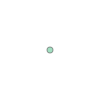

In [154]:
pd.DataFrame(test2["geometry"].value_counts()).reset_index()["geometry"][0]

In [155]:
test2[test2["geometry"] == pd.DataFrame(test2["geometry"].value_counts()).reset_index()["geometry"][0]]

,CODSABER,CODPRES,CENTRO_EDU,CORREO,REGIONAL,CIRCUITO,PROVINCIA,CANTON,DISTRITO,POBLADO,...,geometry,codigo,region,year,school_name,province,cires,canton,distrito,poblado
1824,103094,2965,LA FUENTE,None,DIRECCIÓN REGIONAL COTO,CIRCUITO 09,PUNTARENAS,CORREDORES,CORREDOR,CAÑO SECO,...,POINT (616100.919 958558.513),102965,COTO,2016,LA FUENTE,PUNTARENAS,9,CORREDORES,CORREDOR,LA FUENTE
1825,103094,2965,LA FUENTE,None,DIRECCIÓN REGIONAL COTO,CIRCUITO 09,PUNTARENAS,CORREDORES,CORREDOR,CAÑO SECO,...,POINT (616100.919 958558.513),103078,COTO,2016,LA FUENTE,PUNTARENAS,9,CORREDORES,CORREDOR,22 DE OCTUBRE


In [157]:
df[df["codigo"].isin(["102965", "103078"])]

,year,codigo,school_name,region,cires,province,canton,distrito,poblado,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_nota_no_incluye_los_datos_del_curso_lectivo_2017_sector,...,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_3_rm03,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rt04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rh04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_4_rm04,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rt05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rh05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_5_rm05,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rt06,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rh06,estudiantes_repitentes_en_i_y_ii_ciclos_2014_2022_6_rm06
3005,2014,102965,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,LA FUENTE,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3130,2014,103078,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,22 DE OCTUBRE,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4087,2015,102965,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,LA FUENTE,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6748,2015,103078,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,22 DE OCTUBRE,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8126,2016,102965,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,LA FUENTE,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10786,2016,103078,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,22 DE OCTUBRE,1,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12173,2018,102965,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,LA FUENTE,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14821,2018,103078,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,22 DE OCTUBRE,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16210,2019,102965,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,LA FUENTE,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18854,2019,103078,LA FUENTE,COTO,9,PUNTARENAS,CORREDORES,CORREDOR,22 DE OCTUBRE,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [188]:
test2["CODSABER"].value_counts()

CODSABER
100677    1
102813    1
102811    1
102808    1
102804    1
         ..
101862    1
101858    1
101856    1
101855    1
103556    1
Name: count, Length: 1196, dtype: int64

In [189]:
test2

,CODSABER,CODPRES,CENTRO_EDU,CORREO,REGIONAL,CIRCUITO,PROVINCIA,CANTON,DISTRITO,POBLADO,...,geometry,codigo,region,year,school_name,province,cires,canton,distrito,poblado
0,100677,0474,OJO DE AGUA,esc.ojodeaguaaserri@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 03,SAN JOSE,ASERRI,VUELTA DE JORCO,OJO DE AGUA,...,POINT (486471.401 1083835.390),10474,DIRECCIÓN REGIONAL DESAMPARADOS,2016,OJO DE AGUA,SAN JOSE,3,ASERRI,VUELTA DE JORCO,OJO DE AGUA
1,100678,0475,AGUA BLANCA,esc.aguablanca@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 05,SAN JOSE,ACOSTA,PALMICHAL,AGUA BLANCA,...,POINT (479930.253 1084811.741),10475,DIRECCIÓN REGIONAL DESAMPARADOS,2016,AGUA BLANCA,SAN JOSE,5,ACOSTA,PALMICHAL,AGUA BLANCA
2,100679,0476,LINDA VISTA,esc.lindavistarioazul@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 01,CARTAGO,LA UNION,RIO AZUL,LINDA VISTA,...,POINT (497188.824 1092991.392),10476,DIRECCIÓN REGIONAL DESAMPARADOS,2016,LINDA VISTA,CARTAGO,1,LA UNION,RIO AZUL,LINDA VISTA
3,100680,0477,FINCA CAPRI,esc.fincacapri@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 02,SAN JOSE,DESAMPARADOS,SAN MIGUEL,CAPRI,...,POINT (493387.264 1090994.557),10477,DIRECCIÓN REGIONAL DESAMPARADOS,2016,FINCA CAPRI,SAN JOSE,2,DESAMPARADOS,SAN MIGUEL,CAPRI
4,100681,0478,SAUREZ,esc.saurez@mep.go.cr,DIRECCIÓN REGIONAL DESAMPARADOS,CIRCUITO 03,SAN JOSE,ASERRI,SALITRILLOS,LOURDES,...,POINT (489270.099 1089461.396),10478,DIRECCIÓN REGIONAL DESAMPARADOS,2016,SAUREZ,SAN JOSE,3,ASERRI,SALITRILLOS,LOURDES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,105057,6648,MOLLEJONES,esc.mollejones.alajuela@mep.go.cr,DIRECCIÓN REGIONAL ALAJUELA,CIRCUITO 09,ALAJUELA,OROTINA,COYOLAR,MOLLEJONES,...,POINT (437891.084 1092674.105),106648,DIRECCIÓN REGIONAL ALAJUELA,2016,MOLLEJONES,ALAJUELA,9,OROTINA,COYOLAR,MOLLEJONES
1192,101604,1422,EL ACHIOTE,None,DIRECCIÓN REGIONAL SAN CARLOS,CIRCUITO 12,ALAJUELA,SAN CARLOS,POCOSOL,PUEBLO NUEVO,...,POINT (449133.850 1185583.020),101422,DIRECCIÓN REGIONAL SAN CARLOS,2016,EL ACHIOTE,ALAJUELA,12,SAN CARLOS,POCOSOL,PUEBLO NUEVO
1193,102036,1867,RIO BLANCO,esc.rioblanco@mep.go.cr,DIRECCIÓN REGIONAL LOS SANTOS,CIRCUITO 02,SAN JOSE,DOTA,COPEY,RIO BLANCO,...,POINT (512141.294 1066643.848),101867,DIRECCIÓN REGIONAL LOS SANTOS,2016,RIO BLANCO,SAN JOSE,2,DOTA,COPEY,RIO BLANCO
1194,102821,2674,SABALITO,esc.sabalitotilaran@mep.go.cr,DIRECCIÓN REGIONAL CAÑAS,CIRCUITO 03,GUANACASTE,TILARAN,TIERRAS MORENAS,SABALITO,...,POINT (390762.992 1167885.511),102674,DIRECCIÓN REGIONAL CAÑAS,2016,SABALITO,GUANACASTE,3,TILARAN,TIERRAS MORENAS,SABALITO
